In [1]:
import wandb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('dark')

In [2]:
exp_names = [
    'GraphVAE (vector)',
    'VAE baseline',
    'ILCM-weakly_supervised (GT Interv)',
    'ILCM-weakly_supervised (Infer Interv)',
    'BIOLS_learnL',
    'BIOLS_learnSCM'
]

label_dict = {
    'GraphVAE (vector)': 'GraphVAE',
    'VAE baseline': 'VAE',
    'ILCM-weakly_supervised (GT Interv)': 'ILCM-GT',
    'ILCM-weakly_supervised (Infer Interv)': 'ILCM',
    'BIOLS_learnL': 'BIOLS-fixed',
    'BIOLS_learnSCM': 'BIOLS',
}

metrics = {
    'SHD': ['SHD', 'SHD', 'SHD (Perm)', 'SHD (Perm)', 'SHD', 'SHD', ],
    'AUROC': ['AUROC', 'AUROC', 'AUROC (Perm)', 'AUROC (Perm)', 'AUROC', 'AUROC']
}

metrics_per_exp_name = {
    'GraphVAE (vector)': ['SHD', 'AUROC'],
    'VAE baseline': ['SHD', 'AUROC'],
    'ILCM-weakly_supervised (GT Interv)': ['SHD (Perm)', 'AUROC (Perm)'],
    'ILCM-weakly_supervised (Infer Interv)': ['SHD (Perm)', 'AUROC (Perm)'],
    'BIOLS_learnL': ['SHD', 'AUROC'],
    'BIOLS_learnSCM': ['SHD', 'AUROC']
}

In [3]:
def get_reqd_runs(exp_config, runs, num_seeds=5):
    reqd_runs = []

    for run in runs:
        reqd_run = True
        for k,v in exp_config.items():
            if k not in run.config.keys() or run.config[k] != v: 
                reqd_run = False
                break
        if reqd_run is False: continue
        else: reqd_runs.append(run)   # This is a required run
        
    print(f"Fetched {len(reqd_runs)} runs")
    assert len(reqd_runs) == num_seeds
    return reqd_runs

In [4]:
api = wandb.Api(timeout=40)
runs = api.runs("structurelearning/BIOLS")
max_steps = 20000

In [5]:
def get_plotting_data(reqd_runs, reqd_keys):
    seed_data = {}
    for key in reqd_keys: seed_data[key] = []

    for run in reqd_runs:
        plotting_data = run.scan_history(reqd_keys, max_steps)

        for key in reqd_keys:
            seed_data[key].append([data[key] for data in plotting_data])
    
    for key in reqd_keys:
        seed_data[key] = np.array([x for x in seed_data[key] if x])

    return seed_data

#### SON projection, 5 nodes

In [6]:
def get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC']):
    plot_data_dict = {
        'Graph density': [],
        'Model': [],
        'biols_data_folder': []
    }
    
    for key in reqd_keys:   plot_data_dict[key] = []

    for exp_name in exp_names:
        exp_config['exp_name'] = exp_name
        exp_run = get_reqd_runs(exp_config, runs, num_seeds=5)
        reqd_keys = ['Evaluations/' + key for key in metrics_per_exp_name[exp_name]]
        plotting_data = get_plotting_data(exp_run, reqd_keys)

        splits = exp_config['biols_data_folder'].split('-')
        exp_edges = int(splits[0][-1])
        d = int(splits[3][1:])
        D = int(splits[4][1:])

        for key in reqd_keys:
            num_seeds = len(plotting_data[key][:, -1])
            if 'SHD' in key:
                lhs_key = 'SHD'
            elif 'AUROC' in key:
                lhs_key = 'AUROC'
            plot_data_dict[lhs_key] += (plotting_data[key][:, -1]).tolist()
        
        plot_data_dict['Graph density'] += [f'd={d}, ER-{exp_edges}'] * num_seeds

        label = label_dict[exp_name]
        plot_data_dict['Model'] += [label] * num_seeds
        plot_data_dict['biols_data_folder'] += [exp_config['biols_data_folder']] * num_seeds

    plot_df = pd.DataFrame(plot_data_dict)
    return plot_df

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


,Graph density,Model,biols_data_folder,SHD,AUROC
0,"d=5, ER-1",GraphVAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,6.000000,0.733333
1,"d=5, ER-1",GraphVAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,13.000000,0.297619
2,"d=5, ER-1",GraphVAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,14.000000,0.200000
3,"d=5, ER-1",GraphVAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,11.000000,0.375000
4,"d=5, ER-1",GraphVAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,12.000000,0.235294
5,"d=5, ER-1",VAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,5.000000,0.500000
6,"d=5, ER-1",VAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,5.000000,0.500000
7,"d=5, ER-1",VAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,4.000000,0.500000
8,"d=5, ER-1",VAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,6.000000,0.500000
9,"d=5, ER-1",VAE,er1-ws_datagen_fix_noise_interv_noise-SONproj-...,3.000000,0.500000


In [287]:
def plot_it(label_dict, plot_df):
    num_rows = 1
    num_cols = 2
    colors = ['#ea4335', '#f4b400', '#2ca02c', '#4c8bf5', '#9467bd', '#17becf']

    models = list(label_dict.values())

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))
    lines_labels = []

    # Iterate over the metrics
    for i, metric in enumerate(['SHD', 'AUROC']):
        # Extract the metric values for each model and seed
        data = []
        for model in models:
            model_data = plot_df[plot_df['Model'] == model][metric]
            data.append(model_data)

        # Plot the data in the subplot
        ax = axs[i]
        # ax.boxplot(data, labels=models, showfliers=False, patch_artist=True)
        PROPS = {
            'boxprops':{'alpha':0.3},
            'medianprops':{'alpha':0.5},
            'whiskerprops':{'alpha':0.5},
            'capprops':{'alpha':0.5}
        }
        sns.boxplot(ax=ax, x='Graph density', y=metric, data=plot_df, hue='Model', showfliers = False, palette=colors, **PROPS)
        sns.stripplot(
            ax=ax, 
            x="Graph density", 
            y=metric, 
            data=plot_df, 
            hue='Model', 
            dodge=True, 
            alpha=.7, 
            palette=colors, 
            ec='k',
            jitter=True,
            legend=False
        )
        
        box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
        if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
            box_patches = ax.artists
        num_patches = len(box_patches)
        lines_per_boxplot = len(ax.lines) // num_patches

        for k, patch in enumerate(box_patches):
            col = patch.get_facecolor()
            patch.set_edgecolor(col)

            for line in ax.lines[k * lines_per_boxplot: (k + 1) * lines_per_boxplot]:
                line.set_color(col)
                line.set_mfc(col)  # facecolor of fliers
                line.set_mec(col)  # edgecolor of fliers
        
        ax.set_ylabel(metric)
        ax.grid(axis='y')

        if i == 0:
            lines_labels.append(ax.get_legend_handles_labels())
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    lgd = fig.legend(
        lines, 
        labels, 
        ncol=len(labels), 
        loc='lower center', 
        bbox_to_anchor=[0.5,-0.04], 
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


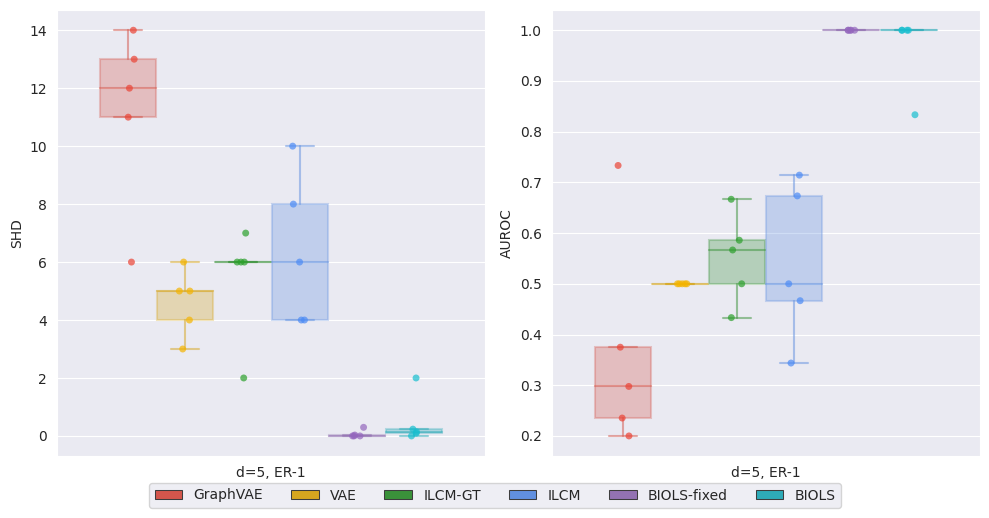

In [288]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-multi-n_pairs2000-sets20-gaussianinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


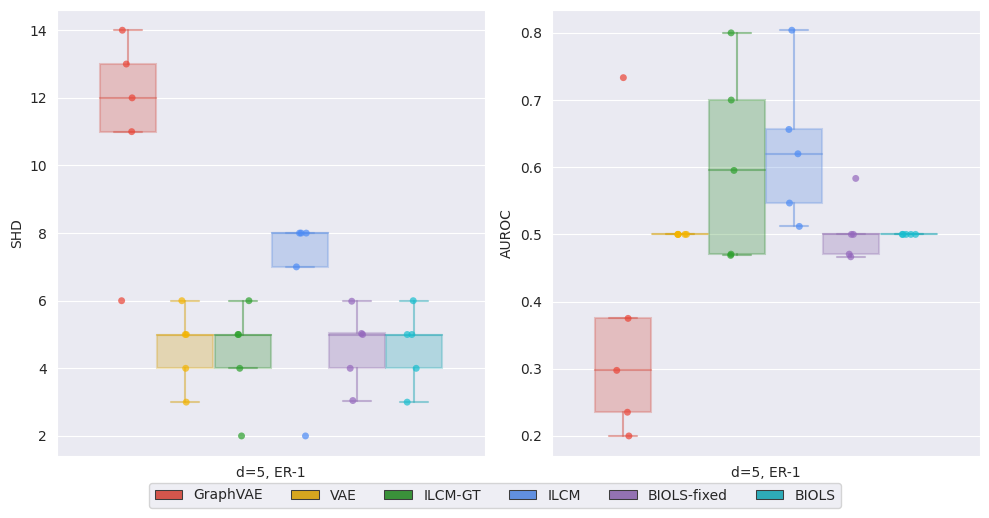

In [289]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-multi-n_pairs2000-sets20-zerosinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


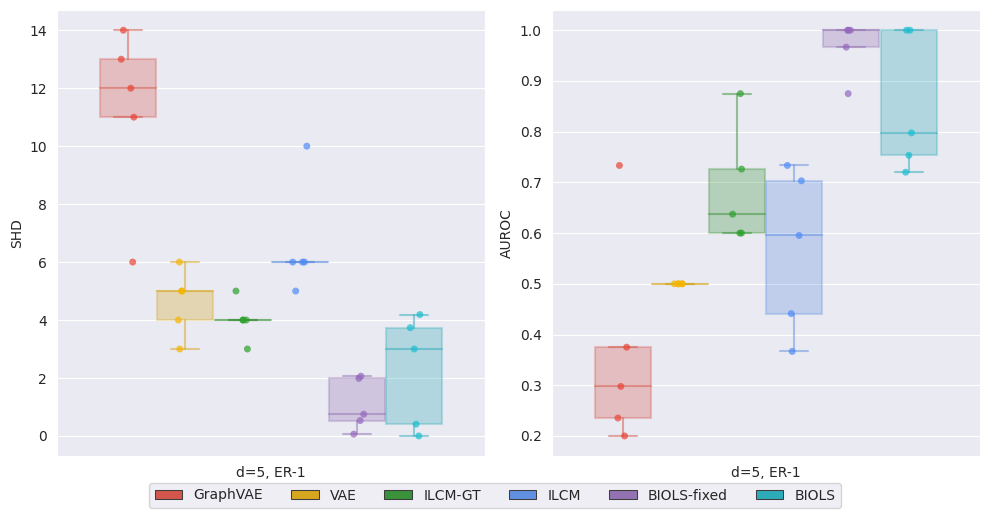

In [290]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-single-n_pairs2000-sets20-gaussianinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


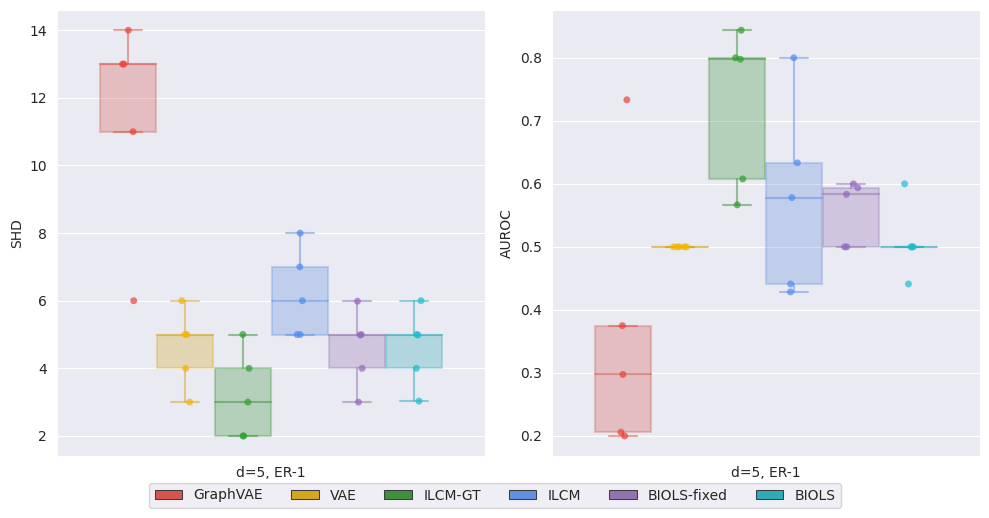

In [291]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-single-n_pairs2000-sets20-zerosinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


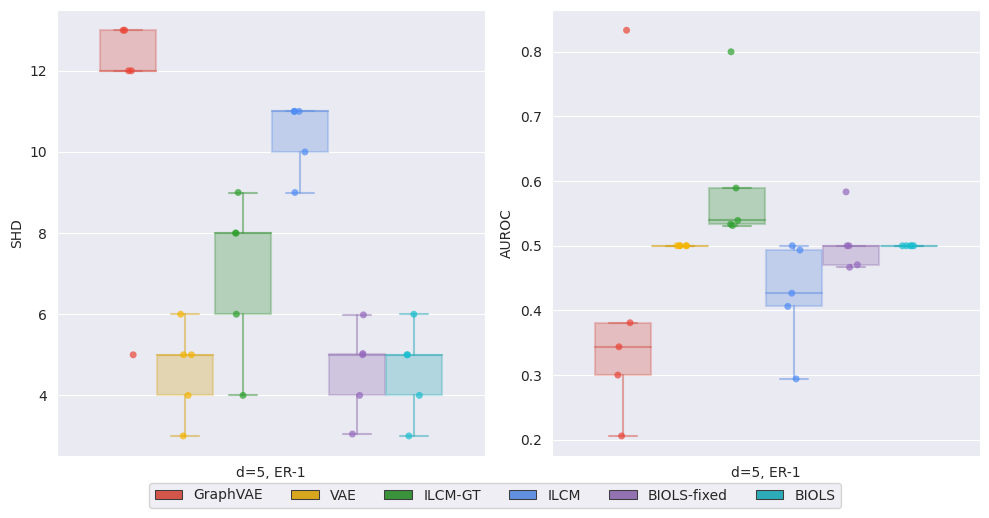

In [292]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-multi-n_pairs2000-sets20-zerosinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


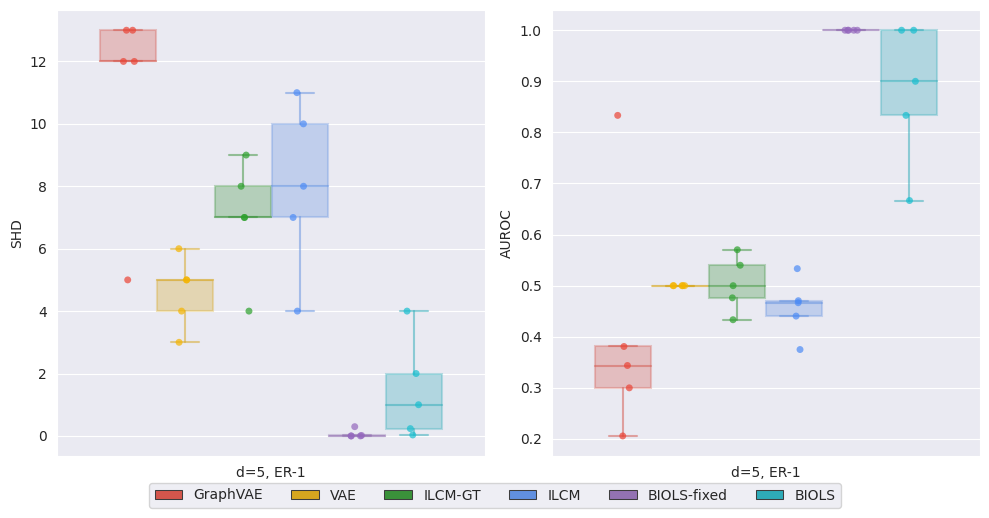

In [293]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


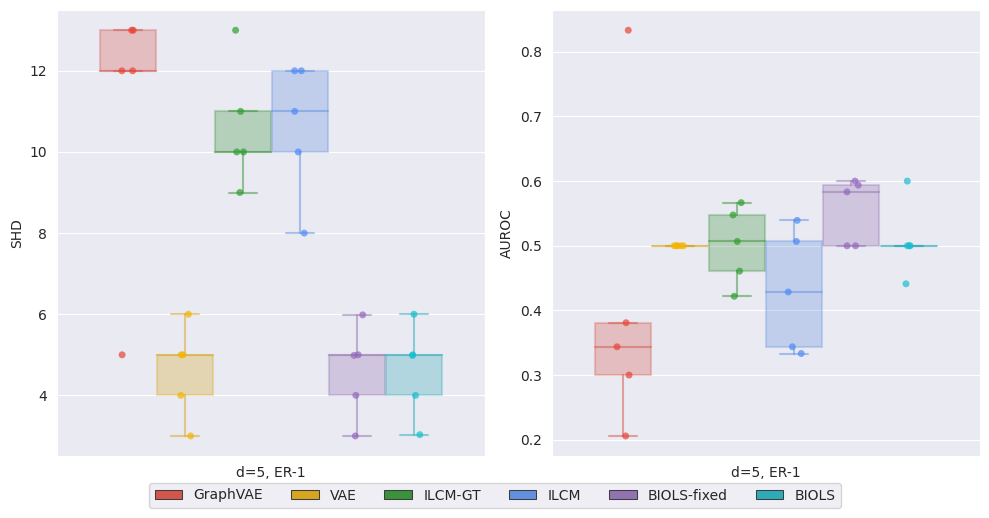

In [295]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-single-n_pairs2000-sets20-zerosinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)

Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs
Fetched 5 runs


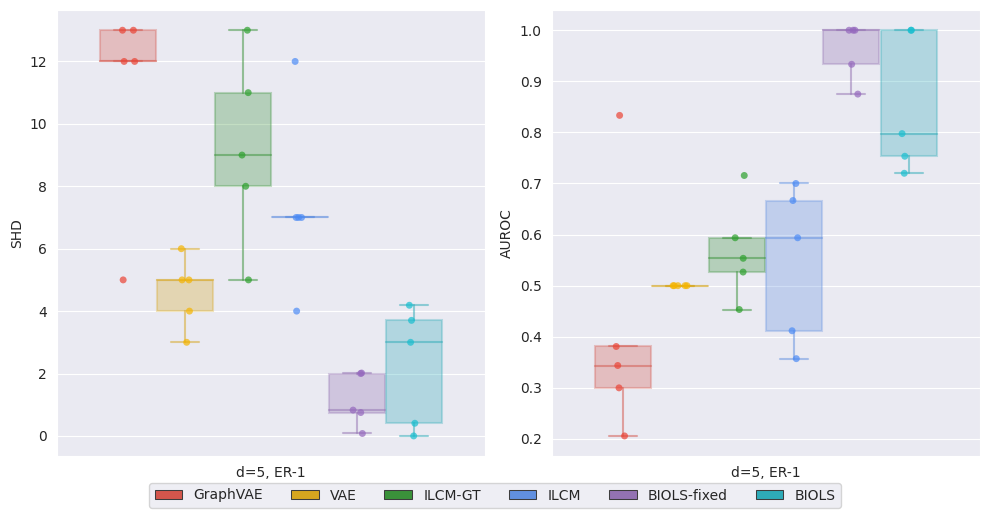

In [294]:
exp_config = {
    'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-single-n_pairs2000-sets20-gaussianinterv'
}
plot_df = get_plot_dataframe(exp_config, exp_names, reqd_keys=['SHD', 'AUROC'])
plot_it(label_dict, plot_df)